# **1. Librerias**

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from deep_translator import GoogleTranslator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import Counter


# **2. Dataset**

## **2.1. Cargar dataset**

In [41]:
df = pd.read_csv("/content/drive/MyDrive/Final_COM300/Emotion_final.csv")

In [42]:
df.head(10)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,happy
9,i feel romantic too,love


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [44]:
print(f"Filas y columnas: {df.shape}")

Filas y columnas: (21459, 2)


<Axes: xlabel='Emotion', ylabel='count'>

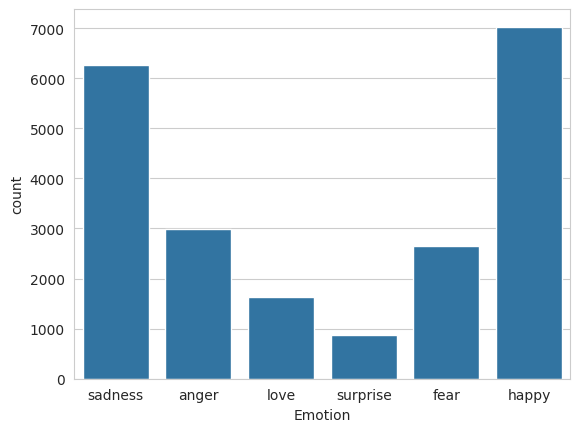

In [45]:
sns.set_style("whitegrid")
sns.countplot(x="Emotion",data = df)

## **2.2. Preprocesamiento**

In [46]:
# Limpiar texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Solo letras y espacios
    tokens = text.split()
    return tokens

df['tokens'] = df['Text'].apply(clean_text)

In [47]:
# Construir vocabulario
all_tokens = [token for sublist in df['tokens'] for token in sublist]
vocab = sorted(set(all_tokens))
word2idx = {word: idx+2 for idx, word in enumerate(vocab)}  # +2 para reservar 0 (PAD) y 1 (UNK)
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

vocab_size = len(word2idx)

In [48]:
# Convertir tokens a índices
def tokens_to_indices(tokens):
    return [word2idx.get(token, 1) for token in tokens]  # 1 = <UNK>

df['input_ids'] = df['tokens'].apply(tokens_to_indices)

In [49]:
# Codificar etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Emotion'])
num_classes = len(label_encoder.classes_)

In [50]:
# Ver clases disponibles
print("Emociones codificadas:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Emociones codificadas: {'anger': np.int64(0), 'fear': np.int64(1), 'happy': np.int64(2), 'love': np.int64(3), 'sadness': np.int64(4), 'surprise': np.int64(5)}


In [51]:
# 5. Padding/truncamiento
max_len = 20

def pad_sequence(seq, max_len=max_len):
    if len(seq) < max_len:
        return seq + [0]*(max_len - len(seq))
    else:
        return seq[:max_len]

df['input_ids'] = df['input_ids'].apply(lambda x: pad_sequence(x, max_len))

In [52]:
# 6. Dataset personalizado
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [53]:
# 7. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df['input_ids'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [54]:
train_dataset = EmotionDataset(X_train, y_train)
test_dataset = EmotionDataset(X_test, y_test)

In [55]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# **3. Modelo de Red Neuronal**

## **3.1. Definición del modelo**

In [56]:
class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(EmotionClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embeds = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = embeds.mean(dim=1)      # Global Average Pooling → (batch_size, embed_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # (batch_size, num_classes)
        return x


## **3.2. Instanciar el modelo**

In [80]:
embed_dim = 400
model = EmotionClassifier(vocab_size=len(word2idx), embed_dim=embed_dim, num_classes=num_classes)

## **3.3. Elegimos optimizador y función de pérdida**

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **4. Entrenamiento y evaluación**

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [83]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [84]:
# Para guardar métricas
history = {
    "epoch": [],
    "train_loss": [],
    "test_acc": []
}
epochs = 10
for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)

    # Guardar métricas
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["test_acc"].append(test_acc)

    print(f"Epoch {epoch}/{epochs} — Loss: {train_loss:.4f} — Test Accuracy: {test_acc:.4f}")

Epoch 1/10 — Loss: 1.4512 — Test Accuracy: 0.5902
Epoch 2/10 — Loss: 0.7882 — Test Accuracy: 0.7759
Epoch 3/10 — Loss: 0.4188 — Test Accuracy: 0.7992
Epoch 4/10 — Loss: 0.2720 — Test Accuracy: 0.8022
Epoch 5/10 — Loss: 0.1889 — Test Accuracy: 0.8022
Epoch 6/10 — Loss: 0.1353 — Test Accuracy: 0.8041
Epoch 7/10 — Loss: 0.0997 — Test Accuracy: 0.7971
Epoch 8/10 — Loss: 0.0718 — Test Accuracy: 0.8017
Epoch 9/10 — Loss: 0.0548 — Test Accuracy: 0.7957
Epoch 10/10 — Loss: 0.0421 — Test Accuracy: 0.7982


# **5. Gráfica**

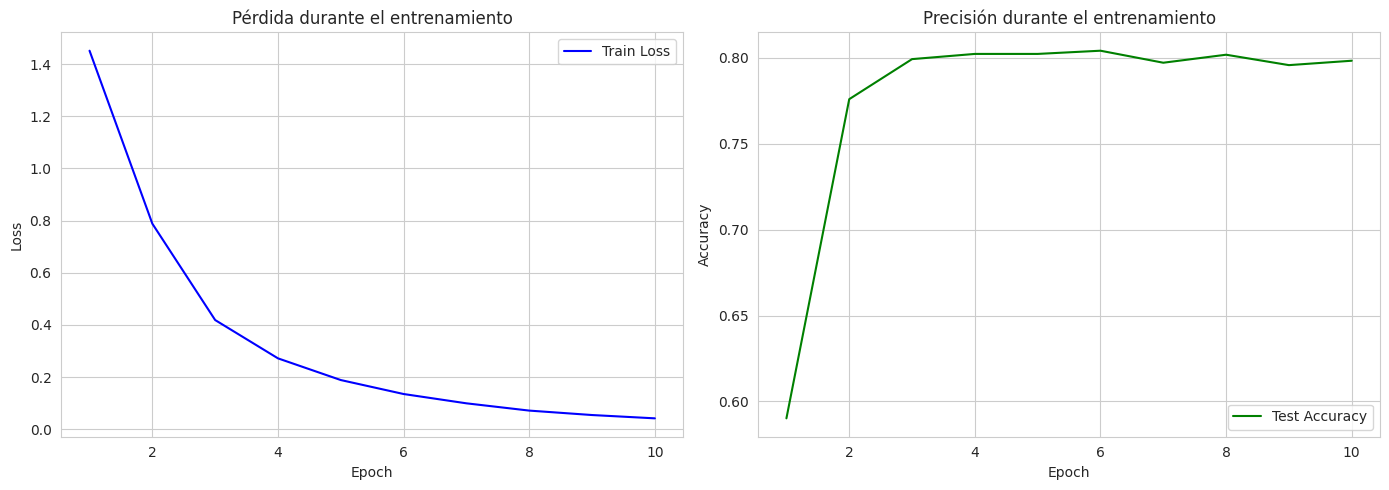

In [85]:
plt.figure(figsize=(14, 5))

# Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['test_acc'], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()

# **6. Enviar emoción detectada a Blender**

## **6.1. Función para preprocesar texto nuevo y para predecir emoción**

In [63]:
# Función para preprocesar texto nuevo
def preprocess_text(text):
    tokens = clean_text(text)
    indices = tokens_to_indices(tokens)
    padded = pad_sequence(indices, max_len)
    return torch.tensor(padded, dtype=torch.long).unsqueeze(0)  # batch=1

# Función para predecir emoción
def predict_emotion(model, text):
    model.eval()
    input_tensor = preprocess_text(text).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    emotion_label = label_encoder.inverse_transform([pred])[0]
    return emotion_label

## **6.2. Implementación o verificación**

In [64]:
def test_prompt(prompt):
    emotion = predict_emotion(model, prompt)
    print(f"Texto: \"{prompt}\"")
    print(f"Emoción detectada: {emotion}")
    return emotion

In [65]:
test_prompt(
    "But I'm a creep, Im a weirdo, What the hell am I doing here?, I don't belong here"
    )

Texto: "But I'm a creep, Im a weirdo, What the hell am I doing here?, I don't belong here"
Emoción detectada: sadness


'sadness'

In [66]:
!pip install deep-translator

In [67]:
def traducir_es_a_en(texto_es):
    return GoogleTranslator(source='auto', target='en').translate(texto_es)

In [68]:
emociones_en_es = {
    "anger": "ira",
    "disgust": "asco",
    "fear": "miedo",
    "happy": "alegría",
    "neutral": "neutral",
    "sadness": "tristeza",
    "surprise": "sorpresa",
    "love": "amor"
}

In [69]:
def predict_emotion_es(model, texto_es):
    texto_en = traducir_es_a_en(texto_es)
    model.eval()
    input_tensor = preprocess_text(texto_en).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    emotion_en = label_encoder.inverse_transform([pred])[0]
    emotion_es = emociones_en_es.get(emotion_en, emotion_en)
    return emotion_es

In [70]:
def guardar_emocion_blender(emocion, archivo="emocion.txt"):
    with open(archivo, "w") as f:
        f.write(emocion)

In [71]:
texto = "El dia es tan bonito hoy, soleado y perfecto para un picnic"
emocion = predict_emotion_es(model, texto)
guardar_emocion_blender(emocion)
print(f"Emoción detectada y guardada: {emocion}")

Emoción detectada y guardada: alegría


In [72]:
texto_usuario = "Una mujer golpea la mesa con el puño cerrado. Su rostro rojo y ceño fruncido, respira rápido mientras sus ojos lanzan fuego."
prediccion = predict_emotion_es(model, texto_usuario)
print(f"Emoción detectada: {prediccion}")

Emoción detectada: ira
